Import the neccessary libraries

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt

Set plotting style for better visualization

In [4]:
plt.style.use("seaborn-v0_8-whitegrid")

Configuration and Constants

In [6]:
TICKER = "KO" # Coca-cola company stock ticker
START_DATE = "2010-01-01" # Starting date for data visualization
END_DATE = pd.to_datetime("today").strftime('%Y-%m-%d') # Today's date as end date
PREDICTION_DAYS = 1 # We aim to predict the stock price 1 day into a future

Data Loading and Acquistion

In [8]:
print(f"Fetching {TICKER} stock data from {START_DATE} to {END_DATE}")

# Use yfinane to download historical stock data
try:
    df = yf.download(TICKER,start=START_DATE,end=END_DATE)
except Exception as e:
    print(f"Error fetching data: {e}")
    exit()

Fetching KO stock data from 2010-01-01 to 2025-10-20


C:\Users\Dell\AppData\Local\Temp\ipykernel_12104\4121722960.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER,start=START_DATE,end=END_DATE)
[*********************100%***********************]  1 of 1 completed


In [13]:
# Check if data was successfully loaded and is not empty
if df.empty:
    print(f"No data retrived for {TICKER}. Exiting...")
    exit()

In [14]:
df.reset_index(inplace=True)

In [16]:
# Display the first few rows of the raw data
print("----- Raw Head -----")
df.head()

----- Raw Head -----


Price,index,Date,Close,High,Low,Open,Volume
Ticker,,,KO,KO,KO,KO,KO
0,0,2010-01-04,17.557863,17.613270,17.514769,17.594801,13870400
1,1,2010-01-05,17.345472,17.542476,17.280831,17.499381,23172400
2,2,2010-01-06,17.339315,17.373174,17.231579,17.345471,19264600
3,3,2010-01-07,17.296221,17.351628,17.160782,17.339316,13234600
4,4,2010-01-08,16.976097,17.126927,16.852970,17.071520,28712400


In [17]:
# Display the data information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3973 entries, 0 to 3972
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   (index, )     3973 non-null   int64         
 1   (Date, )      3973 non-null   datetime64[ns]
 2   (Close, KO)   3973 non-null   float64       
 3   (High, KO)    3973 non-null   float64       
 4   (Low, KO)     3973 non-null   float64       
 5   (Open, KO)    3973 non-null   float64       
 6   (Volume, KO)  3973 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 217.4 KB
None


Data Preprocessing

In [18]:
# Check for missing values
df_missing = df.isnull().sum()
print("Missing Values")
print(df_missing)

Missing Values
Price   Ticker
index             0
Date              0
Close   KO        0
High    KO        0
Low     KO        0
Open    KO        0
Volume  KO        0
dtype: int64


In [19]:
# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("Duplicated Rows")
print(df_duplicated)

Duplicated Rows
0


Visualization Before Training

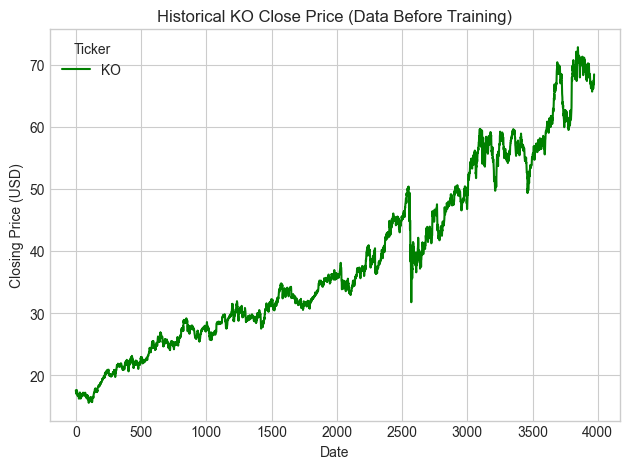

In [44]:
# Display a simple plot showing the historical close price (before training)
plt.Figure(figsize=(14,3))
df["Close"].plot(title=f"Historical {TICKER} Close Price (Data Before Training)",color="green")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.tight_layout()
plt.show()

Feature Engineering

In [20]:
# Create features based on the current day's trading data
features = df[["Open","High","Low","Close","Volume"]].copy()

In [21]:
# 1. Target Variable Creation: We want to predict the "Close" price for the next day
# We shift the "Close" column upward to -PREDICTION_DAYS (1 day) to align the future value
# (Target: y) with current day's features (Input: X)
features["Target"] = features["Close"].shift(-PREDICTION_DAYS)

In [23]:
# 2. Feature Engineering: Adding simple moving averages (SMAs) as technical indicators
# SMAs smooth out price data to identify trend direction
features["SMA_5"] = features["Close"].rolling(window=5).mean()
features["SMA_20"] = features["Close"].rolling(window=20).mean()

In [24]:
# Drop rows with NaN values created by shiftig and rolling window operators
# These NaNs are from the last row (Target) and the first 20 rows (SMA_20)
features.dropna(inplace=True)

In [25]:
# Define the feature matrix (X) and the targte Variable (y)
X =  features.drop("Target",axis=1) # All columns except "Target" are features
y = features["Target"]

C:\Users\Dell\AppData\Local\Temp\ipykernel_12104\2419883420.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X =  features.drop("Target",axis=1) # All columns except "Target" are features


In [26]:
# Store the dates corresponding to the data points for visualization
dates = features.index.values

Data Splitting

In [27]:
# Split the data into training (80%) and testing (20%) sets
# We don't shuffle time series data as the order is cruical
# We use a fixed split point based on the index (time)
split_point = int(0.8  * len(X))
X_train,X_test = X[:split_point],X[split_point:]
y_train,y_test = y[:split_point],y[split_point:]
dates_test = dates[split_point:] # Keep track of the test dates for plotting

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 3162 samples
Testing set size: 791 samples


Data Scaling

In [29]:
# Stanadardize features by removing the mean and scaling to unit variance
# This is crucial for distance-based algorithms like SVR and Linear Models with regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test) # Use the fitted scaler from the training set

In [30]:
# Convert back to DataFrame for better visualization/debugging (optional, but good practice)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)

Hyperparameter Grids

In [37]:
# 1. Linear Models (Ridge/Lasso/ElasticNet): Use 'alpha' (regularization strength)
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}

# 2. Decision Tree: Use 'max_depth' and 'min_samples_split'
dt_params = {
    'max_depth': np.arange(3, 15), # Max depth of the tree
    'min_samples_split': np.arange(2, 10) # Minimum number of samples required to split an internal node
}

# 3. Random Forest: Use 'n_estimators' (number of trees) and 'max_depth'
rf_params = {
    'n_estimators': np.arange(50, 200, 50), # Number of trees in the forest
    'max_depth': np.arange(5, 20),
    'min_samples_leaf': [1, 2, 4]
}

# 4. SVR: Use 'C' (regularization parameter) and 'gamma' (kernel coefficient)
svr_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'], # How much influence a single training example has
    'kernel': ['rbf']
}

Model Definitions

In [38]:
models_to_run = [
    ("Linear Regression (Baseline)",LinearRegression(),{}), # No tuning for simple Linear Regression
    ("Ridge Regression",Ridge(),ridge_params),
    ("Lasso Regression",Lasso(max_iter=5000),lasso_params),
    ("Decision Tree",DecisionTreeRegressor(random_state=42),dt_params),
    ("Random Forest",RandomForestRegressor(random_state=42),rf_params),
    ("SVR",SVR(),svr_params)
]

In [39]:
# Dictionary to store results for comparison
results = {}
best_model = None
best_score = -np.inf # Initialize with negative infinity for R-squared metric (higher is better)

# Define which models require feature scaling (all linear and distance-based models)
SCALED_MODELS = ["Linear Regression (Baseline)","Ridge Regression","Lasso Regression","SVR"]

Model Training and Hyperparameter Tuning

In [40]:
for name, model, params in models_to_run:
    print(f"\nTraining and Tuning: {name}...")

    # Determine the correct training and testing data based on whether the model requires scaling
    requires_scaling = name in SCALED_MODELS

    if requires_scaling:
        X_train_data = X_train_scaled
        X_test_pred = X_test_scaled
    else:
        # Tree-based models (DT, RF) do not benefit from scaling and can use the original data
        X_train_data = X_train
        X_test_pred = X_test

    # If parameters exist, use RandomizedSearchCV for tuning
    if params:
        # RandomizedSearchCV samples a fixed number of parameter settings from the search space.
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=params,
            n_iter=10 if name != "SVR" else 5, # Run 10 iterations (fewer for slow SVR)
            scoring='r2',
            cv=3,
            verbose=0,
            random_state=42,
            n_jobs=-1 # Use all available CPU cores
        )
        
        # Fit the search object to the determined training data
        search.fit(X_train_data, y_train)

        # The best estimator is the model trained with the best hyperparameters
        final_model = search.best_estimator_
        best_params = search.best_params_
        print(f"   Best Params: {best_params}")
    else:
        # For models without tuning (like Linear Regression Baseline), just fit the model directly
        final_model = model
        final_model.fit(X_train_data, y_train)
        best_params = "N/A"

    # Make predictions on the test set using the correctly prepared test data
    y_pred = final_model.predict(X_test_pred)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store results
    results[name] = {'R2 Score': r2, 'MSE': mse, 'Model': final_model, 'Params': best_params, 'Predictions': y_pred}

    print(f"   Test R² Score: {r2:.4f}")
    print(f"   Test MSE: {mse:.4f}")

    # Check for the best model based on R-squared (coefficient of determination)
    if r2 > best_score:
        best_score = r2
        best_model_name = name
        best_model = final_model

# --- Final Comparison and Best Model Selection ---
print("\n--- Final Model Comparison ---")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'R2 Score': [r['R2 Score'] for r in results.values()],
    'MSE': [r['MSE'] for r in results.values()],
    'Best Params': [r['Params'] for r in results.values()]
}).sort_values(by='R2 Score', ascending=False).set_index('Model')
print(comparison_df.round(4))

print(f"\n*** The best performing model based on R² score is: {best_model_name} ***")
best_results = results[best_model_name]



Training and Tuning: Linear Regression (Baseline)...
   Test R² Score: -20.9560
   Test MSE: 764.8624

Training and Tuning: Ridge Regression...


c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


   Best Params: {'alpha': 0.1}
   Test R² Score: -20.9558
   Test MSE: 764.8556

Training and Tuning: Lasso Regression...


c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


   Best Params: {'alpha': 0.001}
   Test R² Score: -20.9560
   Test MSE: 764.8638

Training and Tuning: Decision Tree...
   Best Params: {'min_samples_split': np.int64(3), 'max_depth': np.int64(7)}
   Test R² Score: -0.8033
   Test MSE: 62.8206

Training and Tuning: Random Forest...
   Best Params: {'n_estimators': np.int64(150), 'min_samples_leaf': 1, 'max_depth': np.int64(17)}
   Test R² Score: -0.4106
   Test MSE: 49.1398

Training and Tuning: SVR...
   Best Params: {'kernel': 'rbf', 'gamma': 'auto', 'C': 100}
   Test R² Score: -20.8705
   Test MSE: 761.8829

--- Final Model Comparison ---
                              R2 Score       MSE  \
Model                                              
Random Forest                  -0.4106   49.1398   
Decision Tree                  -0.8033   62.8206   
SVR                           -20.8705  761.8829   
Ridge Regression              -20.9558  764.8556   
Linear Regression (Baseline)  -20.9560  764.8624   
Lasso Regression              -20.95

Visualiztion: Actual vs Predicted (Best Model)

Generating Visualization..........


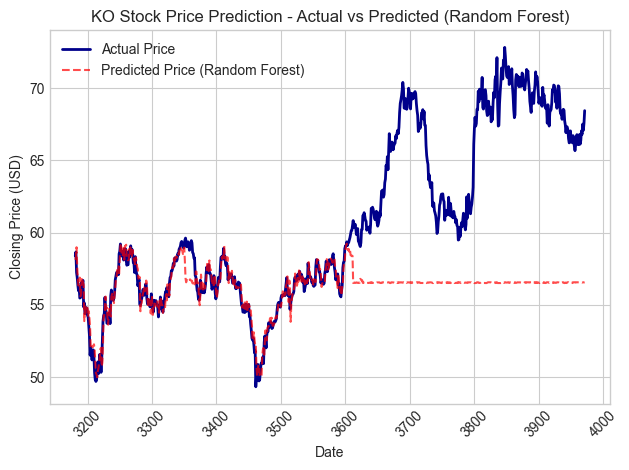

In [46]:
print("Generating Visualization..........")

plt.Figure(figsize=(14,6))

# Plot the actual (true) prices from the test set
plt.plot(dates_test,y_test.values,label="Actual Price",color="darkblue",linewidth=2)

# Plot the predicted prices from the best model
plt.plot(dates_test,best_results["Predictions"],label=f"Predicted Price ({best_model_name})",color="red",linestyle="--",alpha=0.7)
plt.title(f"{TICKER} Stock Price Prediction - Actual vs Predicted ({best_model_name})")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

New Prediction

In [47]:
def predict_next_day_price(model,latest_data):
    print("----- New Prediction Input (Next Trading Day)")


    # The latest data needs to be structured exactly like X_train (Open, High, Low, Close, Volume, SMA_5, SMA_20)
    # The last row of our preprocessed features DataFrame contains the data needed for the prediction.
    last_row = latest_data.iloc[-1].drop("Target")

    # Since the Random Forest was chosen as the best model, we do not need to scale it
    # If the best model was LinearRegression/Lasso/Ridge/SVR,scaling would be mandatory

    # 1. Reshape the data for prediction (single sample)
    X_new = last_row.values.reshape(1,-1)

    # 2. Check if scaling is needed for the best model
    # Note: SCALED_MODELS is a global constant defined in the main script now
    is_scaled = best_model_name in SCALED_MODELS


    if is_scaled:
        # Only scale the features if the best model requires scaled input (i-e., not a tree-based model)
        X_new_scaled = scaler.transform(X_new)
        prediction = model.predict(X_new_scaled)
    else:
        prediction = model.predict(X_new)

    print(f"Latest input features used for prediction (today's data):")
    print(last_row.to_frame().T)

    print(f"Predicted {TICKER} Closing Price fo the Next Trading Day:")
    print(f"${prediction[0]:.2f} (Using {best_model_name})")


    return prediction[0]




# Execute the prediction function using the best model and the last row of the original features

predict_next_day_price(best_model,features)

----- New Prediction Input (Next Trading Day)
Latest input features used for prediction (today's data):
Price    Open       High        Low      Close      Volume      SMA_5  SMA_20
Ticker     KO         KO         KO         KO          KO                   
3971    67.18  68.110001  67.160004  67.589996  15707200.0  67.204001  66.537
Predicted KO Closing Price fo the Next Trading Day:
$56.56 (Using Random Forest)


C:\Users\Dell\AppData\Local\Temp\ipykernel_12104\4131575431.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  last_row = latest_data.iloc[-1].drop("Target")


np.float64(56.55947052001953)